*IMPORTANCE SAMPLING*


Técnica utilizada en estadísticas y simulaciones para estimar propiedades de una distribución de interés utilizando muestras generadas desde otra distribución más fácil de muestrear. La idea fundamental es asignar ponderaciones a las muestras para corregir sesgos introducidos por la elección de la distribución de muestreo.

1.Fórmula general de "importance sampling":
\begin{equation}
\hat{\mu} = \frac{1}{N} \sum_{i=1}^{N} \frac{f(x_i)}{g(x_i)} \cdot h(x_i)
\end{equation}

- $\mu$  es la estimación de la propiedad de interés.
- $\N$ es el número de muestras.
- $x_i$ son las muestras generadas a partir de la distribución $g(x)$.
- $f(x)$ es la función que queremos estimar.
- $g(x)$ es la distribución de muestreo (desde donde se generan las muestras).
- $h(x)$ es una función auxiliar que a menudo es 1.


2.Estimador insesgado de la varianza:
\begin{equation}
\hat{\sigma}^2 = \frac{1}{N-1} \sum_{i=1}^{N} \left( \frac{f(x_i)}{g(x_i)} \cdot h(x_i) - \hat{\mu} \right)^2
\end{equation}



In [24]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm, uniform
import random

***Paso 1: Definición de $f(x)$***
 
$f(x)$ es la función que queremos integrar o, en este caso, calcular su esperanza bajo una cierta distribución. La elección de $f(x)=x^2$ es arbitraria 

In [25]:
def f(x):
    return x**2

***Paso 2: Generación de Muestras de $p(x)$***
 
$p(x)$ es la función de densidad de probabilidad (PDF) de la distribución normal $N(0,1)$. La función muestra_norm genera 10000 muestras de esta distribución, pero solo conserva las primeras 1000 que caen en el intervalo [0, 3]. Luego, se calcula $f(x)$ para cada muestra $x$ generada.

In [26]:
def muestra_norm(e, s):
    muestra = np.random.normal(e, s, 10000)
    rango_min = 0
    rango_max = 3
    muestra_recortada = np.clip(muestra, rango_min, rango_max)
    return np.array(muestra_recortada[:1000])

esp_p = 0
std_p = 1
def p(x):
    return norm.pdf(x, loc=esp_p, scale=std_p)

norms_p = muestra_norm(esp_p, std_p)
sample_p = [f(x) for x in norms_p]


***Paso 3: Graficación de $f(x)$ y $p(x)$***

visualiza las funciones $f(x)$ y $p(x)$, así como el producto $p(x)f(x)$. La elección de $p(x)$ como una distribución normal es solo para ilustrar la técnica de "importance sampling".

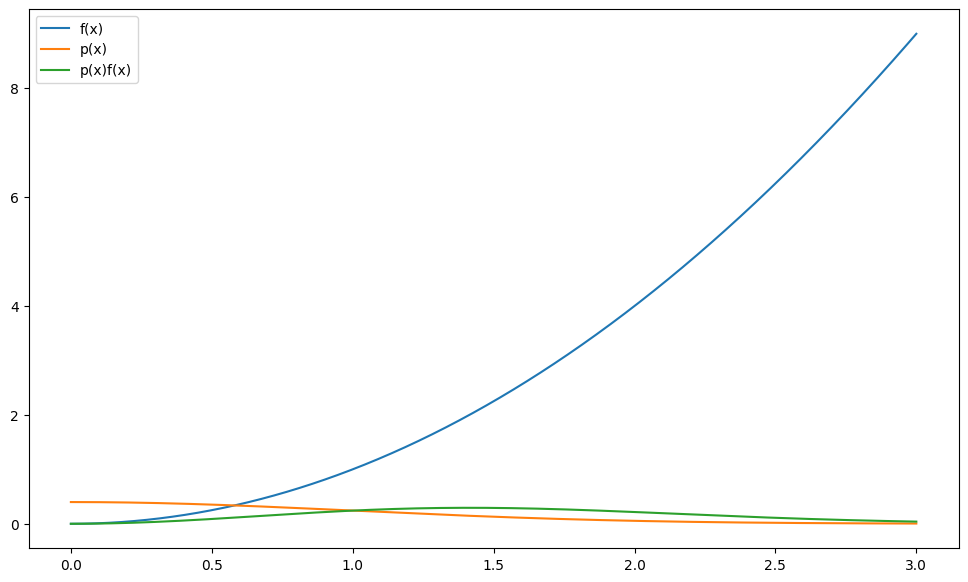

In [27]:
x1 = np.linspace(0, 3, 1000)
p_x = [p(x) for x in x1]
f_x = [f(x) for x in x1]
pf_x = np.array(p_x) * np.array(f_x)

plt.figure(figsize=(12, 7))
plt.plot(x1, f_x, label='f(x)')
plt.plot(x1, p_x, label='p(x)')
plt.plot(x1, pf_x, label='p(x)f(x)')
plt.legend()
plt.show()
plt.close()

***Paso 4: Creación de $q(x)$ y Sampleo de $x$ desde $q(x)$***

se crea una segunda distribución $q(x)$ que será utilizada para el "importance sampling". La elección de 
$q(x)$ como una distribución normal diferente $N(1.9,0.8)$ es nuevamente arbitraria

In [28]:
esp_q = 1.9
std_q = 0.8

def q(x):
    return norm.pdf(x, loc=esp_q, scale=std_q)
    
q_x = [q(x) for x in x1]

***Paso 5: Graficación de $q(x)$ y $p(x)f(x)$***

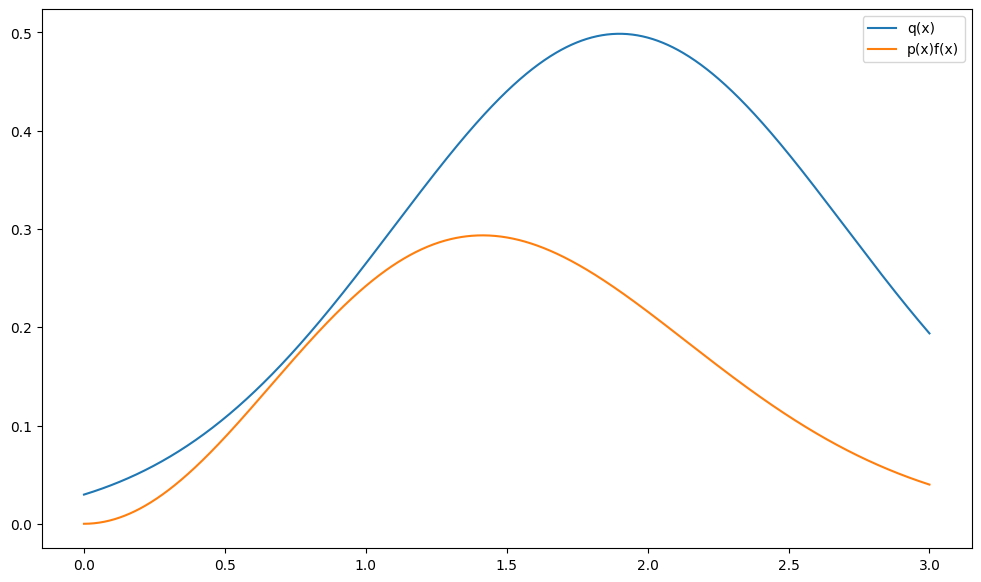

In [29]:
plt.figure(figsize=(12, 7))
plt.plot(x1, q_x, label='q(x)')
plt.plot(x1, pf_x, label='p(x)f(x)')
plt.legend()
plt.show()
plt.close()

***Paso 6: Estimación de $E_q\left[\frac{p(x)f(x)}{q(x)}\right]$***


Se generan muestras $x$ desde $q(x)$, y se calculan las ponderaciones $w_i = \frac{p(x_i)f(x_i)}{q(x)}$. Finalmente, se estima la esperanza $E_q\left[\frac{p(x)f(x)}{q(x)}\right]$ tomando el promedio de las ponderaciones.


In [30]:
norms_q = muestra_norm(esp_q, std_q)
sample_q = [p(x) * f(x) / q(x) for x in norms_q]
print(f"Eq[p(x)f(x)/q(x)] = {round(np.mean(sample_q), 3)}")


Eq[p(x)f(x)/q(x)] = 0.489


***Paso 7: Comparación de Sampleo con $p(x)$ y $q(x)$***

Si las muestras generadas con $q(x)$ son visualmente similares a las generadas con $p(x)$, esto podría indicar que $q(x)$ está capturando bien la forma de $p(x)$ y que las ponderaciones $w_i$ en el Paso 6 no son muy grandes, lo cual es deseable para obtener una buena estimación.


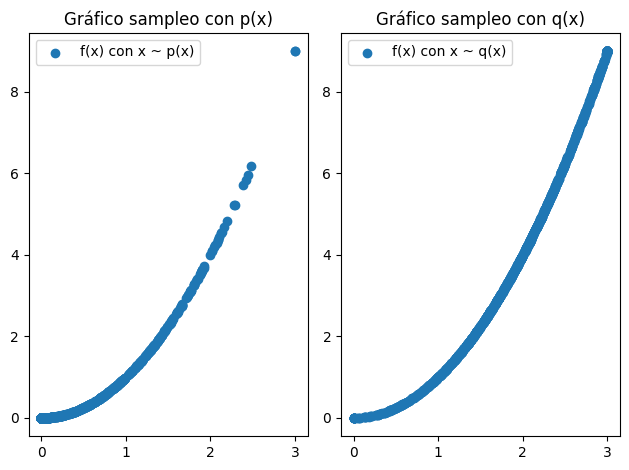

In [31]:
plt.figure()
plt.subplot(1, 2, 1) 
plt.scatter(norms_p, sample_p, label='f(x) con x ~ p(x)')
plt.title('Gráfico sampleo con p(x)')
plt.legend()

plt.subplot(1, 2, 2)  
plt.scatter(norms_q, [f(x) for x in norms_q], label='f(x) con x ~ q(x)')
plt.title('Gráfico sampleo con q(x)')
plt.legend()

plt.tight_layout()
plt.show()

***Paso 8: Comparación de Esperanzas y Varianzas***

la estimación de las esperanzas y varianzas de las muestras generadas bajo $p(x)$ y $q(x)$ para comparar su rendimiento. Puedes observar cómo la varianza de la estimación puede cambiar con diferentes distribuciones de muestreo. La comparación de varianzas es fundamental para entender cómo "importance sampling" puede mejorar la eficiencia en ciertos casos.


In [32]:
prom_p = []
prom_q = []
for _ in range(30):
    norms_p = muestra_norm(esp_p, std_p)
    sample_p = [f(x) for x in norms_p]
    prom_p.append(np.mean(sample_p))

    norms_q = muestra_norm(esp_q, std_q)
    sample_q = [p(x) * f(x) / q(x) for x in norms_q]
    prom_q.append(np.mean(sample_q))

print(f"Esperanza p: {np.mean(prom_p)} \nVarianza p: {np.var(prom_p)}")
print(f"\n \nEsperanza q: {np.mean(prom_q)} \nVarianza q: {np.var(prom_q)}")


Esperanza p: 0.5028850710846994 
Varianza p: 0.0009826799128498846

 
Esperanza q: 0.5041326318664912 
Varianza q: 5.0642076784837915e-05


*EJERCICIO:*

Estimar la entropía de la uniforme cuando la distribución que provee las muestras en una N(3,1)

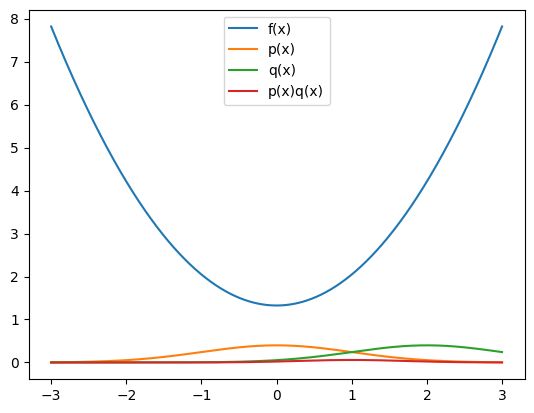

Entropía verdadera de la distribución uniforme:  1.584962500721156
Entropía estimada utilizando importance sampling:  2.4890726673906185


In [39]:
# Paso 1: Definir la función objetivo y las distribuciones p(x) y q(x)
f = lambda x: -np.log2(p(x))

pmu, psigma = 0, 1  # parámetros de la distribución normal
p = lambda x: 1 / (psigma * np.sqrt(2 * np.pi)) * np.exp(- (x - pmu) ** 2 / (2 * psigma ** 2))  # distribución normal

# Propongo una distribución q que sea una normal centrada en 1
qmu, qsigma = 2, 1  # parámetros de la distribución normal
q = lambda x: 1 / (qsigma * np.sqrt(2 * np.pi)) * np.exp(- (x - qmu) ** 2 / (2 * qsigma ** 2))  # distribución normal

# Paso 2: Visualizar las distribuciones
t = np.linspace(-3, 3, 1000)
plt.plot(t, f(t), label='f(x)')
plt.plot(t, p(t), label='p(x)')
plt.plot(t, q(t), label='q(x)')
plt.plot(t, p(t) * q(t), label='p(x)q(x)')
plt.legend()
plt.show()

# Paso 3: Generar N muestras de la distribución q y calcular los pesos
N = 10000
samples_q = np.random.normal(qmu, qsigma, N)

# Mantener solo las muestras en el intervalo [-3, 3]
samples_q = samples_q[(samples_q > -3) & (samples_q < 3)]

# Calcular los pesos de cada muestra
weights = p(samples_q) / q(samples_q)

# Paso 4: Calcular la entropía utilizando importance sampling
entropy_estimate = np.mean(weights * f(samples_q))

# Imprimir resultados
print("Entropía verdadera de la distribución uniforme: ", np.log2(3))
print("Entropía estimada utilizando importance sampling: ", entropy_estimate)
